<a href="https://colab.research.google.com/github/Kaushik-Shahare/foodan_ped_unet/blob/main/Unet_Dice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2023-04-13 10:11:52--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  54.6MB/s    in 0.9s    

2023-04-13 10:11:53 (54.6 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-04-13 10:11:53--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-04-13 10:11:53--
Total wall clock time: 1.1s
Downloaded: 1 files, 51M in 0.9s (54.6 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [2]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH_IMG = '/content/PennFudanPed/PNGImages/'
TRAIN_PATH_LABEL = '/content/PennFudanPed/PedMasks/'



In [4]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH_IMG))[2]

In [5]:
def generate_mask_for_water(base_img):
    image_to_return = np.copy(base_img)
    image_to_return[image_to_return[:] != 0] = 1
    image_to_return[image_to_return[:] == 0] = 0
    return image_to_return

In [6]:
mask_numbers = []

for filename in os.listdir(TRAIN_PATH_IMG):
    mask_numbers.append(filename)
print(mask_numbers)

['PennPed00076.png', 'FudanPed00028.png', 'PennPed00081.png', 'PennPed00065.png', 'PennPed00053.png', 'FudanPed00010.png', 'FudanPed00062.png', 'PennPed00014.png', 'FudanPed00051.png', 'FudanPed00047.png', 'FudanPed00052.png', 'FudanPed00009.png', 'FudanPed00014.png', 'FudanPed00025.png', 'PennPed00095.png', 'PennPed00047.png', 'FudanPed00072.png', 'PennPed00013.png', 'PennPed00017.png', 'FudanPed00048.png', 'PennPed00082.png', 'PennPed00015.png', 'PennPed00040.png', 'FudanPed00046.png', 'FudanPed00064.png', 'FudanPed00065.png', 'PennPed00059.png', 'FudanPed00043.png', 'PennPed00002.png', 'PennPed00049.png', 'PennPed00092.png', 'PennPed00020.png', 'FudanPed00056.png', 'PennPed00072.png', 'PennPed00093.png', 'FudanPed00024.png', 'PennPed00091.png', 'PennPed00022.png', 'PennPed00078.png', 'FudanPed00016.png', 'FudanPed00066.png', 'FudanPed00027.png', 'PennPed00052.png', 'PennPed00089.png', 'FudanPed00015.png', 'PennPed00064.png', 'FudanPed00040.png', 'FudanPed00059.png', 'FudanPed00057.p

In [7]:
image_mask_dict = {}

for filename in os.listdir(TRAIN_PATH_IMG):
    img_number = filename.split(".png")[0]
    
    indices = [i for i, s in enumerate(mask_numbers) if img_number in s]

    # print(mask_numbers[indices[0]])

    image_mask_dict[filename] = mask_numbers[indices[0]]

print(image_mask_dict)

{'PennPed00076.png': 'PennPed00076.png', 'FudanPed00028.png': 'FudanPed00028.png', 'PennPed00081.png': 'PennPed00081.png', 'PennPed00065.png': 'PennPed00065.png', 'PennPed00053.png': 'PennPed00053.png', 'FudanPed00010.png': 'FudanPed00010.png', 'FudanPed00062.png': 'FudanPed00062.png', 'PennPed00014.png': 'PennPed00014.png', 'FudanPed00051.png': 'FudanPed00051.png', 'FudanPed00047.png': 'FudanPed00047.png', 'FudanPed00052.png': 'FudanPed00052.png', 'FudanPed00009.png': 'FudanPed00009.png', 'FudanPed00014.png': 'FudanPed00014.png', 'FudanPed00025.png': 'FudanPed00025.png', 'PennPed00095.png': 'PennPed00095.png', 'PennPed00047.png': 'PennPed00047.png', 'FudanPed00072.png': 'FudanPed00072.png', 'PennPed00013.png': 'PennPed00013.png', 'PennPed00017.png': 'PennPed00017.png', 'FudanPed00048.png': 'FudanPed00048.png', 'PennPed00082.png': 'PennPed00082.png', 'PennPed00015.png': 'PennPed00015.png', 'PennPed00040.png': 'PennPed00040.png', 'FudanPed00046.png': 'FudanPed00046.png', 'FudanPed00064.

In [8]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

<ipython-input-8-032132e078f6>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [9]:
n=0
for id_ in train_ids:
    path = TRAIN_PATH_IMG + id_
    print(path)
    img = imread(path)[:,:,:IMG_CHANNELS]
   
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    n=n+1

/content/PennFudanPed/PNGImages/PennPed00076.png
/content/PennFudanPed/PNGImages/FudanPed00028.png
/content/PennFudanPed/PNGImages/PennPed00081.png
/content/PennFudanPed/PNGImages/PennPed00065.png
/content/PennFudanPed/PNGImages/PennPed00053.png
/content/PennFudanPed/PNGImages/FudanPed00010.png
/content/PennFudanPed/PNGImages/FudanPed00062.png
/content/PennFudanPed/PNGImages/PennPed00014.png
/content/PennFudanPed/PNGImages/FudanPed00051.png
/content/PennFudanPed/PNGImages/FudanPed00047.png
/content/PennFudanPed/PNGImages/FudanPed00052.png
/content/PennFudanPed/PNGImages/FudanPed00009.png
/content/PennFudanPed/PNGImages/FudanPed00014.png
/content/PennFudanPed/PNGImages/FudanPed00025.png
/content/PennFudanPed/PNGImages/PennPed00095.png
/content/PennFudanPed/PNGImages/PennPed00047.png
/content/PennFudanPed/PNGImages/FudanPed00072.png
/content/PennFudanPed/PNGImages/PennPed00013.png
/content/PennFudanPed/PNGImages/PennPed00017.png
/content/PennFudanPed/PNGImages/FudanPed00048.png
/content/

In [10]:
n=0    
# Now we take all masks associated with that image and combine them into one single mask
for curr_image in image_mask_dict:
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sample_img_labels_path = TRAIN_PATH_LABEL+image_mask_dict[curr_image].split(".png")[0]+"_mask.png"
    print(sample_img_labels_path)
    mask_ = imread(sample_img_labels_path)
    mask_ = generate_mask_for_water(mask_)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                    preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

    Y_train[n] = mask
    n=n+1

<ipython-input-10-345457e7aaae>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


/content/PennFudanPed/PedMasks/PennPed00076_mask.png
/content/PennFudanPed/PedMasks/FudanPed00028_mask.png
/content/PennFudanPed/PedMasks/PennPed00081_mask.png
/content/PennFudanPed/PedMasks/PennPed00065_mask.png
/content/PennFudanPed/PedMasks/PennPed00053_mask.png
/content/PennFudanPed/PedMasks/FudanPed00010_mask.png
/content/PennFudanPed/PedMasks/FudanPed00062_mask.png
/content/PennFudanPed/PedMasks/PennPed00014_mask.png
/content/PennFudanPed/PedMasks/FudanPed00051_mask.png
/content/PennFudanPed/PedMasks/FudanPed00047_mask.png
/content/PennFudanPed/PedMasks/FudanPed00052_mask.png
/content/PennFudanPed/PedMasks/FudanPed00009_mask.png
/content/PennFudanPed/PedMasks/FudanPed00014_mask.png
/content/PennFudanPed/PedMasks/FudanPed00025_mask.png
/content/PennFudanPed/PedMasks/PennPed00095_mask.png
/content/PennFudanPed/PedMasks/PennPed00047_mask.png
/content/PennFudanPed/PedMasks/FudanPed00072_mask.png
/content/PennFudanPed/PedMasks/PennPed00013_mask.png
/content/PennFudanPed/PedMasks/PennP

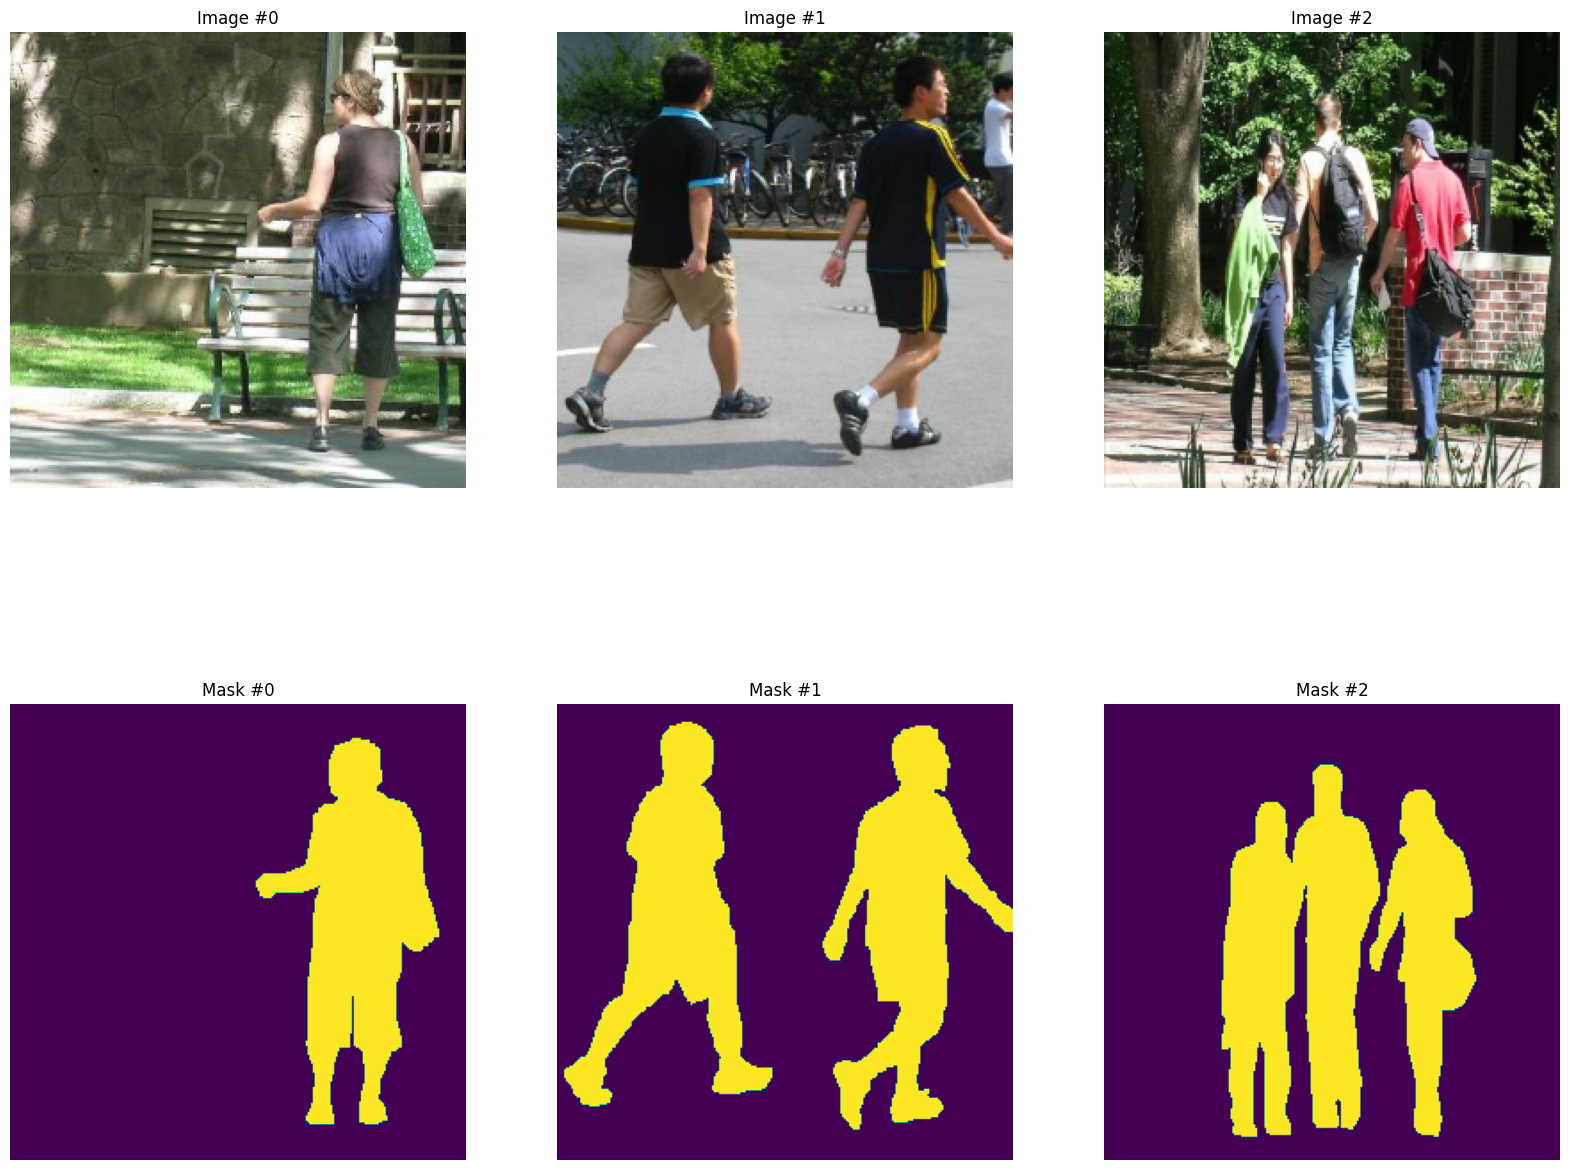

In [11]:
plt.figure(figsize=(20,16))
x, y = 3,1
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*12 + j*1
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]*255))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [12]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run()
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [13]:
# Alternative IoU function
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/51553
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    # flatten
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # one-hot encoding y with 3 labels : 0=background, 1=label1, 2=label2
    y_true_f = K.one_hot(K.cast(y_true_f, np.uint8), 3)
    y_pred_f = K.one_hot(K.cast(y_pred_f, np.uint8), 3)
    # calculate intersection and union exluding background using y[:,1:]
    intersection = K.sum(y_true_f[:,1:]* y_pred_f[:,1:], axis=[-1])
    union = K.sum(y_true_f[:,1:], axis=[-1]) + K.sum(y_pred_f[:,1:], axis=[-1])
    # apply dice formula
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef

In [17]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()
print(model.summary)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [18]:
# Initialize our callbacks
model_path = "net_6.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=100, 
                    callbacks=[earlystop, checkpoint])

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5894 - dice_coef: 0.9012 
Epoch 1: val_loss improved from inf to 0.49866, saving model to net_6.h5
10/10 [==============================] - 147s 14s/step - loss: 0.5894 - dice_coef: 0.9012 - val_loss: 0.4987 - val_dice_coef: 0.9233
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.4956 - dice_coef: 0.9005 
Epoch 2: val_loss improved from 0.49866 to 0.44548, saving model to net_6.h5
10/10 [==============================] - 138s 14s/step - loss: 0.4956 - dice_coef: 0.9005 - val_loss: 0.4455 - val_dice_coef: 0.9233
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.4585 - dice_coef: 0.9007 
Epoch 3: val_loss did not improve from 0.44548
10/10 [==============================] - 132s 13s/step - loss: 0.4585 - dice_coef: 0.9007 - val_loss: 0.5246 - val_dice_coef: 0.9233
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.4253 - dice_coef: 0.9010 
Epoch 4: val_los

In [29]:
New_X_train = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [30]:
New_image = imread(TRAIN_PATH_IMG+"FudanPed00004.png")[:,:,:IMG_CHANNELS]
New_img = resize(New_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
New_X_train[0] = New_img
pred_1 = model.predict(New_X_train, verbose=1)
preds_train_t = (pred_1 > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 454ms/step


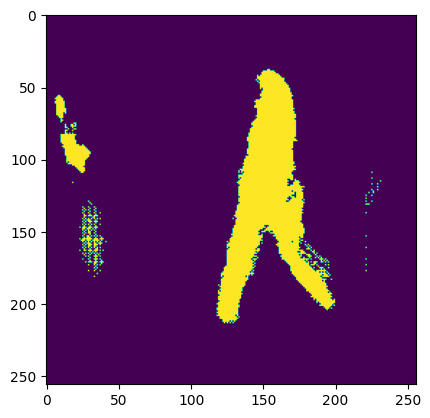

In [31]:
plt.imshow(preds_train_t[0])
plt.show()

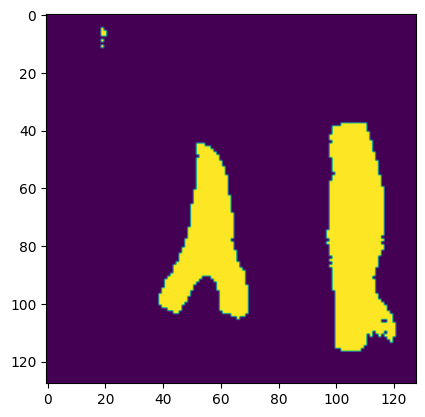

In [ ]:
plt.imshow(preds_train_t[0]*100)
plt.show()

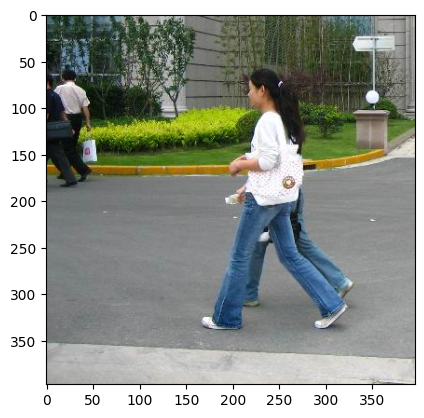

In [32]:
plt.imshow(New_image)
plt.show()